<i>DISCLAIMER:<br>
Bellow code is only for informative purpose, i renounce any responsibility regarding this code and bellow trained model causing loss of money during trading on real market.</i>

# Stock price prediction : NVDA

This page does following:

<b>1. Loading and preparation</b>
- Load data and libraries
- Normalize data based on linear scaling formula
- Split data to train and validation set (train 80%, validation 20%)
- Transform train and validation set into windows, each window has 6 rows (candles), first 5 rows represents formation the model is trained on, the 6th row is label (target price, the model will predict, this is highest price of following week). Windowed data are transformed to tensors for future model training<br>

<b>2. Fun part - model training</b>
- Entry price is High price of last candle in formation
- Model predicts high price of following week
- CNN + LSTM + DNN model is trained and compared to validation dataset used during training
- After model is trained, we let model predict prices on validation dataset<br>

<b>3. Result evaluation</b>
- New dataframe is created with predicted values, normalized data are reverted back to initial values
- We calculate  profit/loss per each trade on validation dataset and final balance is displayed
- Each trade is displayed in chart with target value, predicted value and entry price that trade was entered
- As the last step, prediction of the most recent stock data is made (please refer to page 03_Model_prediction

# 1. Loading and preparation

In [1]:
import tensorflow as tf
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

print("Tensorflow version: ", tf.__version__)

path = "nvda_stock_raw_revised.csv"

data = pd.read_csv(path)

data.head()

Tensorflow version:  2.7.0


,Date,Open,High,Low,Close,EMA6,EMA12,EMA24,trades
0,2019-09-30 00:00:00,43.200001,45.787498,42.532501,45.492500,43.695452,42.715560,42.190845,1081
1,2019-10-07 00:00:00,46.145000,47.334999,44.125000,46.497501,44.496037,43.297397,42.535377,1081
2,2019-10-14 00:00:00,46.410000,49.822498,46.097500,47.622501,45.389313,43.962798,42.942347,1081
3,2019-10-21 00:00:00,48.240002,51.345001,47.757500,51.134998,47.030937,45.066213,43.597759,1081
4,2019-10-28 00:00:00,51.575001,52.224998,49.452499,50.647499,48.064241,45.924872,44.161739,1081


<b>Get data and plot chart</b>

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.title("AAPL close price")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
import csv
time_step = []

opens = []
highs = []
lows = []
closes = []
ema1 = []
ema2 = []
ema3 = []

new = []

final = []
with open(path) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
   # next(reader)

    for row in reader:
        #print(row)
        
        time_step.append(row[0])
        opens.append(float(row[1]))
        highs.append(float(row[2]))
        lows.append(float(row[3]))
        closes.append(float(row[4]))
        ema1.append(row[5])
        ema2.append(row[6])
        ema3.append(row[7])

        
#Get series
series = np.array(closes[::])
time = np.array(time_step[::])

#Plot chart
#plt.figure(figsize=(10, 6))
#plot_series(time, series)
print("done")

done


Get data in dataframe and prepare for windowing, we will be getting windows of 4 candles each, thus we need to have dataframe divisible by 4

In [4]:
dicti = {'Date':time,
         'opens':opens,
         'high':highs,
         'low':lows,
         'close':closes,
         'ema6':ema1,
         'ema12':ema2,
         'ema24':ema3}

temp_old = pd.DataFrame(dicti)
temp_old.head(26)

,Date,opens,high,low,close,ema6,ema12,ema24
0,2019-09-30 00:00:00,43.200001,45.787498,42.532501,45.492500,43.695451509675486,42.71555967641739,42.190844828938964
1,2019-10-07 00:00:00,46.145000,47.334999,44.125000,46.497501,44.49603718499421,43.29739686055179,42.53537735248713
2,2019-10-14 00:00:00,46.410000,49.822498,46.097500,47.622501,45.38931266736473,43.96279755481937,42.942347274151444
3,2019-10-21 00:00:00,48.240002,51.345001,47.757500,51.134998,47.03093713998429,45.066213057390726,43.59775935794198
4,2019-10-28 00:00:00,51.575001,52.224998,49.452499,50.647499,48.06424055269525,45.924872446172564,44.16173853606443
5,2019-11-04 00:00:00,51.462502,52.924999,51.027500,51.945000,49.173028879017814,46.851045869042046,44.78439942876522
6,2019-11-11 00:00:00,51.937500,52.965000,50.160000,51.047501,49.708592230827456,47.49665429078197,45.28544752329213
7,2019-11-18 00:00:00,50.972500,53.637501,50.942501,52.722500,50.56970869270879,48.300630530263525,45.880411709221725
8,2019-11-25 00:00:00,54.009998,55.352501,53.880001,54.185001,51.602649458589426,49.20591835226775,46.544778882347266
9,2019-12-02 00:00:00,54.115002,54.250000,50.092499,53.042500,52.01403519677425,49.796161612262914,47.06459653513839


In [5]:
for row in range(temp_old.shape[0]):
    if temp_old.iloc[row,4] == "":
        temp_old.iloc[row,4] = temp_old.iloc[row,3]
    if temp_old.iloc[row,5] == "":
        temp_old.iloc[row,5] = temp_old.iloc[row,4]
    if temp_old.iloc[row,6] == "":
        temp_old.iloc[row,6] = temp_old.iloc[row,5]
    if temp_old.iloc[row,7] == "":
        temp_old.iloc[row,7] = temp_old.iloc[row,6]
temp_old.head(25)       

,Date,opens,high,low,close,ema6,ema12,ema24
0,2019-09-30 00:00:00,43.200001,45.787498,42.532501,45.492500,43.695451509675486,42.71555967641739,42.190844828938964
1,2019-10-07 00:00:00,46.145000,47.334999,44.125000,46.497501,44.49603718499421,43.29739686055179,42.53537735248713
2,2019-10-14 00:00:00,46.410000,49.822498,46.097500,47.622501,45.38931266736473,43.96279755481937,42.942347274151444
3,2019-10-21 00:00:00,48.240002,51.345001,47.757500,51.134998,47.03093713998429,45.066213057390726,43.59775935794198
4,2019-10-28 00:00:00,51.575001,52.224998,49.452499,50.647499,48.06424055269525,45.924872446172564,44.16173853606443
5,2019-11-04 00:00:00,51.462502,52.924999,51.027500,51.945000,49.173028879017814,46.851045869042046,44.78439942876522
6,2019-11-11 00:00:00,51.937500,52.965000,50.160000,51.047501,49.708592230827456,47.49665429078197,45.28544752329213
7,2019-11-18 00:00:00,50.972500,53.637501,50.942501,52.722500,50.56970869270879,48.300630530263525,45.880411709221725
8,2019-11-25 00:00:00,54.009998,55.352501,53.880001,54.185001,51.602649458589426,49.20591835226775,46.544778882347266
9,2019-12-02 00:00:00,54.115002,54.250000,50.092499,53.042500,52.01403519677425,49.796161612262914,47.06459653513839


Get test data of most recent market data in case of entire dataset is shuffled

In [6]:
# def GetTestSet(df,split_ratio=0.8,window_size=25):
#     #split_ratio = 0.8

#     print("temp_old ",len(temp_old))
#     ttl = len(temp_old)/window_size

#     print("temp_old / windowsize: ",ttl)

#     new_ttl = ttl*window_size
#     print("total len: ", new_ttl)

#     trainsubset = round(new_ttl*split_ratio,0)

#     print("raw trainsubset: ",trainsubset)
#     trainsubset = round(new_ttl*split_ratio,0)
#     print("get 80% of train set: ", trainsubset)

#     train_windows = round(trainsubset/window_size)

#     border_line = train_windows*25
#     df_test = df.iloc[border_line:,:]
    
#     return df_test

# test_df = GetTestSet(temp_old,split_ratio=0.8,window_size=25)
# #test_df.head(25)

<b>Reshuffle Dataset (if needed)</b>

since we are having windowed dataset, in order to do shuffle, we must reshaped data from 2D to 3D array, shuffle each window separately (so that structure is not broken) and than reshape 3D array back to 2D and create again dataframe

In [7]:
# from sklearn.utils import shuffle
# #3D reshaping
# temp = temp_old.values.reshape(-1,25,temp_old.shape[1])
# #shuffling
# sh = shuffle(temp)
# #sh = np.squeeze(sh)
# sh

In [8]:
# aa = sh.reshape(temp_old.shape[0],temp_old.shape[1])
# temp_old = pd.DataFrame(aa,columns=temp_old.columns)
# temp_old.tail(26)

Get dataframe divisible by 25, since <b>24 candles represents formation</b>, 1 candle is label

In [9]:
print("Initial length of dataframe: ",len(temp_old))
formations = int(len(temp_old)/25)
print("Nr of formations: ", formations)
ttl = int(formations*25)
print("New length of dataframe: ",ttl)

Initial length of dataframe:  3025
Nr of formations:  121
New length of dataframe:  3025


<b>Get final dataframe</b>
- get temp dataframe that has excluded Date column
- get new Dates column separately for future reference

In [10]:
initial_df = temp_old.iloc[:ttl,1:]
len_initial = len(initial_df)
print("Len initial_df: ",len_initial)
initial_df.head(2)

Len initial_df:  3025


,opens,high,low,close,ema6,ema12,ema24
0,43.200001,45.787498,42.532501,45.492500,43.695451509675486,42.71555967641739,42.190844828938964
1,46.145000,47.334999,44.125000,46.497501,44.49603718499421,43.29739686055179,42.53537735248713


In [11]:
Dates = temp_old.iloc[:len_initial,0]
Dates.head(2)

0    2019-09-30 00:00:00
1    2019-10-07 00:00:00
Name: Date, dtype: object

In [12]:
initial_df.head(20)

,opens,high,low,close,ema6,ema12,ema24
0,43.200001,45.787498,42.532501,45.492500,43.695451509675486,42.71555967641739,42.190844828938964
1,46.145000,47.334999,44.125000,46.497501,44.49603718499421,43.29739686055179,42.53537735248713
2,46.410000,49.822498,46.097500,47.622501,45.38931266736473,43.96279755481937,42.942347274151444
3,48.240002,51.345001,47.757500,51.134998,47.03093713998429,45.066213057390726,43.59775935794198
4,51.575001,52.224998,49.452499,50.647499,48.06424055269525,45.924872446172564,44.16173853606443
5,51.462502,52.924999,51.027500,51.945000,49.173028879017814,46.851045869042046,44.78439942876522
6,51.937500,52.965000,50.160000,51.047501,49.708592230827456,47.49665429078197,45.28544752329213
7,50.972500,53.637501,50.942501,52.722500,50.56970869270879,48.300630530263525,45.880411709221725
8,54.009998,55.352501,53.880001,54.185001,51.602649458589426,49.20591835226775,46.544778882347266
9,54.115002,54.250000,50.092499,53.042500,52.01403519677425,49.796161612262914,47.06459653513839


<b>We must fill empty values of week candles of ema colls

In [13]:
# for row in range(initial_df.shape[0]):
#     if initial_df.iloc[row,4] == "":
#         initial_df.iloc[row,4] = initial_df.iloc[row,3]
#     if initial_df.iloc[row,5] == "":
#         initial_df.iloc[row,5] = initial_df.iloc[row,4]
#     if initial_df.iloc[row,6] == "":
#         initial_df.iloc[row,6] = initial_df.iloc[row,5]
        

In [14]:
for row in range(24,len(initial_df),25):
    candles = initial_df.iloc[row,:4] 
    mean = np.mean(candles)
    #print(mean)
    #print(candles)

    initial_df.iloc[row,4:initial_df.shape[1]] = float(mean)
    
initial_df['ema24'] = initial_df['ema24'].astype('float64')
initial_df['ema12'] = initial_df['ema12'].astype('float64')
initial_df['ema6'] = initial_df['ema6'].astype('float64')

In [15]:
initial_df.tail(26)
print(initial_df.dtypes)

for coll in initial_df.columns:
    initial_df = initial_df.astype('float64')
print(initial_df.dtypes)   

opens    float64
high     float64
low      float64
close    float64
ema6     float64
ema12    float64
ema24    float64
dtype: object
opens    float64
high     float64
low      float64
close    float64
ema6     float64
ema12    float64
ema24    float64
dtype: object


<b>Normalize data</b>

Linear scaling formula: <i>x ′ = ( x − x m i n ) / ( x m a x − x m i n )</i><br>
Reverse linear scaling: <i>x = (x * (maxv-minv)) + minv</i>

Bellow code will take window size which represents formation that is to be traded, and normalize data exactly per window that is alocated. Each window is normalized separately on each other, using linear scaling formula from above

# BATCH SIZE SETTINGS

<b>Set Window Size and Normalize based on windows</b>

Set window size and normalize entire dataset before modelling

In [16]:
window_size = 24+1

batch_size = 16 #Train batchsize 64

batch_valid = 4 #Valid batchsize 8

tf.random.set_seed(7788)
np.random.seed(7788)


In [17]:
def Normalize(df,window_size):
    """
    Get dataframe and window_size as an input
    
    Normalize data based on linear scaling formula
    
    save maxv and minv of each window for future reversion
    
    """
    
    print("\nNormalize dataframe \n")
    
    #Initialize dataitems
    counter = 0
    inc = 0
    Highs = []
    Lows = []

    df_norm = pd.DataFrame()

    #Loop through each window separately to normalize
    for row in range(0,len(df),window_size):
        
        counter += 1
        df_temp = pd.DataFrame()


        #Get maxv and minv of window
        while inc < df.shape[1]: 

            #Get max High
            if row + inc<len(df):
                
                Highs.append(df.iloc[row+inc][1])
                Lows.append(df.iloc[row+inc][2])

                inc += 1
            else:
                break

        #reset inc
        inc = 0

        #Save Max and Min
        maxv = max(Highs)
        minv = min(Lows)
        
        #testing
        maxv = np.max(df.iloc[row:row + window_size,:].to_numpy())
        minv = np.min(df.iloc[row:row + window_size,:].to_numpy())
        #print(maxv)
        #print(minv)
        #break
        #Reset 
        Highs = []
        Lows = []

        #Print first 2 windows for checking
        if counter < 3:
            #Print data windowing
            print("\nWindow:" + str(counter) + "\n " + str(df.iloc[row:row + window_size,:]))
            print("\nMax value is ", maxv)
            print("Min value is ", minv)
            print("\n Normalized:\n "+ str((df.iloc[row:row + window_size,:]-minv)/(maxv-minv)))

        #Merge normalized window to new dataframe
        df_temp = (df.iloc[row:row + window_size,:]-minv)/(maxv-minv)
        df_temp['maxv'] = maxv
        df_temp['minv'] = minv

        df_norm = pd.concat([df_norm,df_temp],axis=0)     

    print("\nDone")
    
    return df_norm
    
df_norm = Normalize(initial_df,window_size)


Normalize dataframe 


Window:1
         opens       high        low      close       ema6      ema12  \
0   43.200001  45.787498  42.532501  45.492500  43.695452  42.715560   
1   46.145000  47.334999  44.125000  46.497501  44.496037  43.297397   
2   46.410000  49.822498  46.097500  47.622501  45.389313  43.962798   
3   48.240002  51.345001  47.757500  51.134998  47.030937  45.066213   
4   51.575001  52.224998  49.452499  50.647499  48.064241  45.924872   
5   51.462502  52.924999  51.027500  51.945000  49.173029  46.851046   
6   51.937500  52.965000  50.160000  51.047501  49.708592  47.496654   
7   50.972500  53.637501  50.942501  52.722500  50.569709  48.300631   
8   54.009998  55.352501  53.880001  54.185001  51.602649  49.205918   
9   54.115002  54.250000  50.092499  53.042500  52.014035  49.796162   
10  52.812500  57.244999  52.724998  55.997501  53.152168  50.750214   
11  56.474998  60.097500  56.192501  59.842499  55.063691  52.149027   
12  60.130001  60.452499  58.9


Done


In [18]:
temp_old.head(6)

,Date,opens,high,low,close,ema6,ema12,ema24
0,2019-09-30 00:00:00,43.200001,45.787498,42.532501,45.492500,43.695451509675486,42.71555967641739,42.190844828938964
1,2019-10-07 00:00:00,46.145000,47.334999,44.125000,46.497501,44.49603718499421,43.29739686055179,42.53537735248713
2,2019-10-14 00:00:00,46.410000,49.822498,46.097500,47.622501,45.38931266736473,43.96279755481937,42.942347274151444
3,2019-10-21 00:00:00,48.240002,51.345001,47.757500,51.134998,47.03093713998429,45.066213057390726,43.59775935794198
4,2019-10-28 00:00:00,51.575001,52.224998,49.452499,50.647499,48.06424055269525,45.924872446172564,44.16173853606443
5,2019-11-04 00:00:00,51.462502,52.924999,51.027500,51.945000,49.173028879017814,46.851045869042046,44.78439942876522


Check <b>not normalized</b> dataframe initial_df

In [19]:
initial_df.tail(6)

,opens,high,low,close,ema6,ema12,ema24
3019,189.800003,196.190002,181.220001,187.199997,188.466373,202.430451,218.628406
3020,191.389999,193.369995,168.690002,169.740005,183.115982,197.401152,214.717334
3021,160.000000,168.679993,153.279999,158.800003,176.168560,191.462513,210.243947
3022,164.750000,171.399994,158.529999,171.259995,174.766113,188.354434,207.125231
3023,173.119995,173.300003,143.919998,145.229996,166.327222,181.719905,202.173612
3024,141.750000,182.440002,140.550003,181.630005,161.592503,161.592503,161.592503


Check <b>normalized</b> dataframe df_norm

In [20]:
df_norm.tail(6)

,opens,high,low,close,ema6,ema12,ema24,maxv,minv
3019,0.330737,0.373649,0.273118,0.313276,0.321781,0.415556,0.524333,289.459991,140.550003
3020,0.341414,0.354711,0.188973,0.196024,0.285850,0.381782,0.498068,289.459991,140.550003
3021,0.130616,0.188906,0.085488,0.122557,0.239195,0.341901,0.468027,289.459991,140.550003
3022,0.162514,0.207172,0.120744,0.206232,0.229777,0.321029,0.447084,289.459991,140.550003
3023,0.218723,0.219932,0.022631,0.031428,0.173106,0.276475,0.413831,289.459991,140.550003
3024,0.008059,0.281311,0.000000,0.275871,0.141310,0.141310,0.141310,289.459991,140.550003


We have added additional columns maxv and minv to each row, this is needed due to future need to revert normalized values back to its initial ones.

<b>Split normalized data to train and validation set</b>

In [21]:
split_ratio = 0.8

print("dfnorm ",len(df_norm))
ttl = len(df_norm)/window_size

print("df_norm / windowsize: ",ttl)

new_ttl = ttl*window_size
print("total len: ", new_ttl)

trainsubset = round(new_ttl*split_ratio,0)

print("raw trainsubset: ",trainsubset)
trainsubset = round(new_ttl*split_ratio,0)
print("get 80% of train set: ", trainsubset)

train_windows = round(trainsubset/window_size)
print("\ntotal windows of {0}% train set: {1} ".format(split_ratio*100,train_windows))

ttl_xtrain = train_windows*window_size
print("\ntotal x_train: ",ttl_xtrain)

print("total x_val: ",(-ttl_xtrain)+len(df_norm))

dfnorm  3025
df_norm / windowsize:  121.0
total len:  3025.0
raw trainsubset:  2420.0
get 80% of train set:  2420.0

total windows of 80.0% train set: 97 

total x_train:  2425
total x_val:  600


In [22]:
print("ttl x_train,",ttl_xtrain)
split = int(ttl_xtrain)

time_train = time[:split]
x_train = df_norm[:split]
time_valid = time[split:]
x_valid = df_norm[split:]
print("x_valid window",len(x_valid)/25)
print("x_train window",len(x_train)/25)

ttl x_train, 2425
x_valid window 24.0
x_train window 97.0


<b>Display normalized train set</b>

In [23]:
x_valid.head(20)

,opens,high,low,close,ema6,ema12,ema24,maxv,minv
2425,0.182871,0.186438,0.124410,0.168025,0.138056,0.086748,0.000000,346.470001,172.678666
2426,0.164976,0.206980,0.085973,0.204161,0.156943,0.104811,0.016333,346.470001,172.678666
2427,0.213079,0.313832,0.211871,0.308884,0.200355,0.136207,0.039737,346.470001,172.678666
2428,0.320047,0.332303,0.279193,0.320795,0.234766,0.164605,0.062222,346.470001,172.678666
2429,0.320219,0.324017,0.270965,0.299792,0.253345,0.185403,0.081227,346.470001,172.678666
2430,0.311646,0.327757,0.262506,0.266534,0.257113,0.197885,0.096052,346.470001,172.678666
2431,0.223149,0.303072,0.195299,0.276949,0.262781,0.210049,0.110524,346.470001,172.678666
2432,0.255602,0.260723,0.168888,0.199903,0.244816,0.208488,0.117674,346.470001,172.678666
2433,0.186208,0.233276,0.131602,0.205024,0.233446,0.207955,0.124662,346.470001,172.678666
2434,0.190293,0.268318,0.186611,0.264348,0.242275,0.216631,0.135837,346.470001,172.678666


In [24]:
x_train_extremes = x_train.iloc[:,7:].copy()
print("Len x_train_extremes: ",len(x_train_extremes))
x_train_extremes.head(1)

Len x_train_extremes:  2425


,maxv,minv
0,79.080002,42.190845


In [25]:
x_valid_extremes = x_valid.iloc[:,7:].copy()
print("len x_valid_extremes: ",len(x_valid_extremes))
x_valid_extremes.head(1)

len x_valid_extremes:  600


,maxv,minv
2425,346.470001,172.678666


<b>Get x_train and x_valid without extreme minv maxv values</b>

In [26]:
x_valid = x_valid.iloc[:,:7].copy()
x_train = x_train.iloc[:,:7].copy()
x_train.head(26)

,opens,high,low,close,ema6,ema12,ema24
0,0.027356,0.097499,0.009262,0.089502,0.040787,0.014224,0.000000
1,0.107190,0.139449,0.052432,0.116746,0.062490,0.029997,0.009340
2,0.114374,0.206881,0.105903,0.147243,0.086705,0.048035,0.020372
3,0.163982,0.248153,0.150902,0.242460,0.131206,0.077946,0.038139
4,0.254388,0.272008,0.196851,0.229245,0.159217,0.101223,0.053427
5,0.251338,0.290984,0.239546,0.264418,0.189275,0.126330,0.070307
6,0.264215,0.292068,0.216030,0.240088,0.203793,0.143831,0.083889
7,0.238055,0.310299,0.237242,0.285495,0.227136,0.165626,0.100018
8,0.320396,0.356789,0.316872,0.325140,0.255137,0.190166,0.118027
9,0.323243,0.326902,0.214200,0.294169,0.266289,0.206167,0.132119


In [27]:
x_train.dtypes

opens    float64
high     float64
low      float64
close    float64
ema6     float64
ema12    float64
ema24    float64
dtype: object

<b>Get windowed train dataset into tensors</b>

we have to make sure we get tensors with exact windows that have been normalized in previous step, thus we have to shift it to size of window, so that there are taken <b>only</b> respective windows to tensor 

Also we are NOT shuffling dataset here, reshufling can be only done  at the beginning before normalization

In [28]:
print("window size: ",window_size)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Get windowed train dataset based on inputs
    """
    
    #This code must be trigered only when using Conv1D layer as input
    #series = tf.expand_dims(series, axis=-1)
    
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    
    #ds = ds.shuffle(shuffle_buffer)
    
    ds = ds.map(lambda w: (w[:-1], w[-1:, 1]))
    
    return ds.batch(batch_size).prefetch(1)

#Initiate
tf.keras.backend.clear_session()
shuffle_buffer_size = len(x_train)


train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print("\nDone")

window size:  25

Done


<b>Check window and compare with dataframe x train</b>

In [29]:
for batch in train_set:
    print(batch)
    break

(<tf.Tensor: shape=(16, 24, 7), dtype=float64, numpy=
array([[[0.02735644, 0.09749894, 0.0092617 , ..., 0.04078723,
         0.01422409, 0.        ],
        [0.10719019, 0.13944895, 0.05243154, ..., 0.0624897 ,
         0.02999667, 0.00933967],
        [0.11437385, 0.20688067, 0.10590253, ..., 0.08670482,
         0.04803451, 0.02037191],
        ...,
        [0.68737423, 0.76653023, 0.49490568, ..., 0.67286719,
         0.57225383, 0.42606754],
        [0.73284824, 0.78699708, 0.60476186, ..., 0.66897641,
         0.58563777, 0.44472209],
        [0.48209705, 0.62563511, 0.31876998, ..., 0.61740244,
         0.5706885 , 0.44822173]],

       [[0.09877302, 0.13133592, 0.04349813, ..., 0.05365111,
         0.02085175, 0.        ],
        [0.10602442, 0.19940336, 0.09747323, ..., 0.07809453,
         0.03905965, 0.01113625],
        [0.15610023, 0.24106483, 0.14289714, ..., 0.12301562,
         0.0692533 , 0.02907081],
        ...,
        [0.7303296 , 0.78498895, 0.60103566, ..., 0.66

In [30]:
x_train.head(24)

,opens,high,low,close,ema6,ema12,ema24
0,0.027356,0.097499,0.009262,0.089502,0.040787,0.014224,0.000000
1,0.107190,0.139449,0.052432,0.116746,0.062490,0.029997,0.009340
2,0.114374,0.206881,0.105903,0.147243,0.086705,0.048035,0.020372
3,0.163982,0.248153,0.150902,0.242460,0.131206,0.077946,0.038139
4,0.254388,0.272008,0.196851,0.229245,0.159217,0.101223,0.053427
5,0.251338,0.290984,0.239546,0.264418,0.189275,0.126330,0.070307
6,0.264215,0.292068,0.216030,0.240088,0.203793,0.143831,0.083889
7,0.238055,0.310299,0.237242,0.285495,0.227136,0.165626,0.100018
8,0.320396,0.356789,0.316872,0.325140,0.255137,0.190166,0.118027
9,0.323243,0.326902,0.214200,0.294169,0.266289,0.206167,0.132119


<b>Get windowed validation dataset into tensors</b>

We have to prepare validation dataset manually to use in our modeling since keras does not allow to use evaluation dataset created via tf.data.Dataset, thus we have to do basic preprocessing manually and pass features and labels separately to model (this was done automaticaly via tf.dataset for train set in previous steps)

In [31]:
print("Len x_valid: ",len(x_valid))
print(len(x_valid)/window_size)
x_valid.head(10)

Len x_valid:  600
24.0


,opens,high,low,close,ema6,ema12,ema24
2425,0.182871,0.186438,0.124410,0.168025,0.138056,0.086748,0.000000
2426,0.164976,0.206980,0.085973,0.204161,0.156943,0.104811,0.016333
2427,0.213079,0.313832,0.211871,0.308884,0.200355,0.136207,0.039737
2428,0.320047,0.332303,0.279193,0.320795,0.234766,0.164605,0.062222
2429,0.320219,0.324017,0.270965,0.299792,0.253345,0.185403,0.081227
2430,0.311646,0.327757,0.262506,0.266534,0.257113,0.197885,0.096052
2431,0.223149,0.303072,0.195299,0.276949,0.262781,0.210049,0.110524
2432,0.255602,0.260723,0.168888,0.199903,0.244816,0.208488,0.117674
2433,0.186208,0.233276,0.131602,0.205024,0.233446,0.207955,0.124662
2434,0.190293,0.268318,0.186611,0.264348,0.242275,0.216631,0.135837


In [32]:
def Window_validation(x_valid,window_size,batch_valid):
    """
    create tensors of validation dataset
    """
    
    #Initialize data items
    counter = 0
    win = []
    ttl = []
    labels = []
    features = []
    temp_labels = []
    window = window_size
    x_valid_np =  x_valid.to_numpy()


    #Loop row by row and skip each window in dataset (due to normalization that was done before)
    for item in range(0,len(x_valid),window_size):

        #Validation to not exceed the end of xvalid
        if item + window > len(x_valid):
            print(item + window)
            break

        #Get features of window
        while counter != window:
            if (counter+item) <= len(x_valid):
                win.append(x_valid_np[counter+item])
            counter += 1

        if counter==window:
            counter = 0

        if counter+item>len(x_valid)-1:
            break

        #Get labels
        temp_labels.append(x_valid_np[item+window_size-1][1]) 

        labels.append(temp_labels)
        features.append(win[:-1])

        win = []
        temp_labels = []

    features = np.expand_dims(features,axis=-1)
    features = np.squeeze(features)

    val_dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    val_dataset = val_dataset.batch(batch_valid)

    print("\nDone")
    
    return val_dataset, labels

val_dataset,labels = Window_validation(x_valid,window_size,batch_valid)

# for batch in val_dataset:
#     print(batch)
#     break


Done


<b>Check window and compare with dataframe x valid</b>

In [33]:
x_valid.head(25)

,opens,high,low,close,ema6,ema12,ema24
2425,0.182871,0.186438,0.124410,0.168025,0.138056,0.086748,0.000000
2426,0.164976,0.206980,0.085973,0.204161,0.156943,0.104811,0.016333
2427,0.213079,0.313832,0.211871,0.308884,0.200355,0.136207,0.039737
2428,0.320047,0.332303,0.279193,0.320795,0.234766,0.164605,0.062222
2429,0.320219,0.324017,0.270965,0.299792,0.253345,0.185403,0.081227
2430,0.311646,0.327757,0.262506,0.266534,0.257113,0.197885,0.096052
2431,0.223149,0.303072,0.195299,0.276949,0.262781,0.210049,0.110524
2432,0.255602,0.260723,0.168888,0.199903,0.244816,0.208488,0.117674
2433,0.186208,0.233276,0.131602,0.205024,0.233446,0.207955,0.124662
2434,0.190293,0.268318,0.186611,0.264348,0.242275,0.216631,0.135837


In [34]:
for batch in val_dataset:
    print(batch)
    break
#batch_size*4

(<tf.Tensor: shape=(4, 24, 7), dtype=float64, numpy=
array([[[0.18287069, 0.18643815, 0.12440975, 0.16802529, 0.13805617,
         0.08674801, 0.        ],
        [0.16497566, 0.20697998, 0.08597281, 0.20416057, 0.15694314,
         0.10481148, 0.01633285],
        [0.21307933, 0.3138323 , 0.21187094, 0.30888384, 0.20035477,
         0.13620723, 0.03973692],
        [0.32004666, 0.33230268, 0.27919304, 0.32079463, 0.23476616,
         0.16460529, 0.06222154],
        [0.32021928, 0.32401696, 0.27096482, 0.29979246, 0.2533451 ,
         0.18540332, 0.08122721],
        [0.31164575, 0.32775704, 0.2625064 , 0.2665342 , 0.25711341,
         0.19788499, 0.09605177],
        [0.22314887, 0.3030723 , 0.19529932, 0.27694897, 0.26278072,
         0.21004868, 0.11052355],
        [0.25560158, 0.26072266, 0.16888836, 0.19990256, 0.24481553,
         0.20848774, 0.11767387],
        [0.18620794, 0.23327593, 0.13160229, 0.20502364, 0.23344642,
         0.2079548 , 0.12466185],
        [0.19029334,

In [35]:
print("Len Labels: ",len(labels))
len(x_valid)/25
batch_size

Len Labels:  24


16

By above code we have preprocessed and divided dataset into train set and validation set. Both sets were transformed into tensors, those tensors will be used in following training part.

# 2. Fun part - model training

<b>Define callbacks</b>

Callbacks used in our model to improve training

In [322]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss',patience=6,mode='min', restore_best_weights=True)#

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=1)

model_checkpoint = ModelCheckpoint(monitor='val_loss', 
                             filepath='./nvda_80_model_checkpoint_recent.h5', 
                             save_best_only=True)

callbacks = [early_stopping,reduce_lr,model_checkpoint]

<b>Define customized loss function</b>

Customized loss function must be defined in order to have better model performance

In [290]:
def sign_penalty(y_true,y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred,0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                   )
    
    return(tf.reduce_mean(loss,axis=-1))

tf.keras.losses.sign_penalty = sign_penalty

In [291]:
# model = tf.keras.models.load_model('nvda_80_model_checkpoint.h5', custom_objects={'sign_penalty': sign_penalty} )
# model

<b>Get Model</b>

In [292]:
tf.random.set_seed(7788)

model = tf.keras.models.Sequential([

    tf.keras.layers.Conv1D(filters=256, kernel_size=10,
                      strides=1, padding="same",
                      activation=tf.nn.selu,
                      input_shape=[None, 7]),
#     tf.keras.layers.Conv1D(filters=512, kernel_size=10,
#                       strides=1, padding="same",
#                       activation=tf.nn.selu,
#                       input_shape=[None, 7]),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    #tf.keras.layers.Dropout(0.2),   
    tf.keras.layers.Dense(1024, activation=tf.nn.selu),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation=tf.nn.selu),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation=tf.nn.selu),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation=tf.nn.selu),   
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation=tf.nn.selu),
    tf.keras.layers.Dense(16, activation=tf.nn.selu),
    tf.keras.layers.Dense(4, activation=tf.nn.selu),
    tf.keras.layers.Dense(3, activation=tf.nn.selu), #4
    tf.keras.layers.Dense(1,activation=tf.nn.relu),
])

#optimizer1 = tf.keras.optimizers.SGD(learning_rate=10e-7, momentum=0.9)
#optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
#optimizer3 = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
#optimizer4 = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name='Adadelta')

optimizer5 = tf.keras.optimizers.Adagrad(learning_rate=0.0001, initial_accumulator_value=0.1, epsilon=1e-07,name='Adagrad')

#    name, gradient_aggregator=None, gradient_transformers=None)


model.compile(loss=sign_penalty,
              optimizer=optimizer5,
              )

model.fit(train_set, epochs=120,callbacks=[callbacks],validation_data=val_dataset)


Epoch 1/120


KeyboardInterrupt: 

In [39]:
# #shuffled
# # Epoch 00096: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
# # 4/4 [==============================] - 2s 564ms/step - loss: 0.0191 - val_loss: 0.0247 - lr: 8.0000e-07

# model = tf.keras.models.load_model('nvda_80_model_checkpoint_recent.h5', custom_objects={'sign_penalty': sign_penalty} )
# #model.save('nvda_80_model_checkpoint_shuffled.h5')
# model

In [370]:
tf.random.set_seed(7788)

model = tf.keras.models.Sequential([

    tf.keras.layers.Conv1D(filters=8, kernel_size=1,
                      strides=1, padding="same",
                      activation=tf.nn.selu,
                      input_shape=[None, 7]),
     tf.keras.layers.Conv1D(filters=16, kernel_size=1,
                      strides=1, padding="same",
                      activation=tf.nn.elu,
                      #input_shape=[None, 7]
                           ),
         tf.keras.layers.Conv1D(filters=32, kernel_size=10,
                      strides=1, padding="same",
                      activation=tf.nn.selu,
                      #input_shape=[None, 7]
                           ),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation=tf.nn.selu),
    tf.keras.layers.Dense(2, activation=tf.nn.selu),
    tf.keras.layers.Dense(1,activation=tf.nn.relu),
    ])

optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
optimizer5 = tf.keras.optimizers.Adagrad(learning_rate=0.0001, initial_accumulator_value=4, epsilon=1e-07,name='Adagrad')

model.compile(loss=sign_penalty,
              optimizer=optimizer5,
              )

model.fit(train_set, epochs=120,callbacks=[callbacks],validation_data=val_dataset)



Epoch 1/120
7/7 [==============================] - 6s 197ms/step - loss: 0.2342 - val_loss: 0.0413 - lr: 1.0000e-04
Epoch 2/120
7/7 [==============================] - 0s 16ms/step - loss: 0.2226 - val_loss: 0.0384 - lr: 1.0000e-04
Epoch 3/120
7/7 [==============================] - 0s 17ms/step - loss: 0.2126 - val_loss: 0.0358 - lr: 1.0000e-04
Epoch 4/120
7/7 [==============================] - 0s 19ms/step - loss: 0.2036 - val_loss: 0.0335 - lr: 1.0000e-04
Epoch 5/120
7/7 [==============================] - 0s 20ms/step - loss: 0.1952 - val_loss: 0.0314 - lr: 1.0000e-04
Epoch 6/120
7/7 [==============================] - 0s 19ms/step - loss: 0.1873 - val_loss: 0.0294 - lr: 1.0000e-04
Epoch 7/120
7/7 [==============================] - 0s 19ms/step - loss: 0.1801 - val_loss: 0.0277 - lr: 1.0000e-04
Epoch 8/120
7/7 [==============================] - 0s 20ms/step - loss: 0.1736 - val_loss: 0.0261 - lr: 1.0000e-04
Epoch 9/120
7/7 [==============================] - 0s 19ms/step - loss: 0.1674 

Epoch 63/120
5/7 [====================>.........] - ETA: 0s - loss: 0.0830
Epoch 00063: ReduceLROnPlateau reducing learning rate to 2.55999976772614e-10.
7/7 [==============================] - 0s 21ms/step - loss: 0.0771 - val_loss: 0.0070 - lr: 1.2800e-09
Epoch 64/120
7/7 [==============================] - 0s 22ms/step - loss: 0.0771 - val_loss: 0.0070 - lr: 2.5600e-10
Epoch 65/120
5/7 [====================>.........] - ETA: 0s - loss: 0.0830
Epoch 00065: ReduceLROnPlateau reducing learning rate to 5.119999424429978e-11.
7/7 [==============================] - 0s 20ms/step - loss: 0.0771 - val_loss: 0.0070 - lr: 2.5600e-10
Epoch 66/120
7/7 [==============================] - 0s 24ms/step - loss: 0.0771 - val_loss: 0.0070 - lr: 5.1200e-11


In [294]:
# tf.random.set_seed(7788)

# model = tf.keras.models.Sequential([

#     tf.keras.layers.Conv1D(filters=8, kernel_size=1,
#                       strides=1, padding="same",
#                       activation=tf.nn.selu,
#                       input_shape=[None, 7]),
#      tf.keras.layers.Conv1D(filters=16, kernel_size=1,
#                       strides=1, padding="same",
#                       activation=tf.nn.elu,
#                       #input_shape=[None, 7]
#                            ),
#          tf.keras.layers.Conv1D(filters=32, kernel_size=10,
#                       strides=1, padding="same",
#                       activation=tf.nn.selu,
#                       #input_shape=[None, 7]
#                            ),
# #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
#     tf.keras.layers.Dense(3, activation=tf.nn.selu),
#     tf.keras.layers.Dense(2, activation=tf.nn.selu),
#     tf.keras.layers.Dense(1,activation=tf.nn.relu),
#     ])

# #optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
# optimizer5 = tf.keras.optimizers.Adagrad(learning_rate=0.0001, initial_accumulator_value=4, epsilon=1e-07,name='Adagrad')

# model.compile(loss=sign_penalty,
#               optimizer=optimizer5,
#               )

# model.fit(train_set, epochs=120,callbacks=[callbacks],validation_data=val_dataset)



# 3. Result evaluation

<b>Make predictions on validation set</b>

window size must be subtracted by 1, since we are doing just predictions, we do not need extra position for label as was required in previous steps when we trained model. We get windowed validation set just for our formation which is consisted of 3 candles

In [371]:
print("Len Xvalid: ", len(x_valid))
print("raw ttl window: ",len(x_valid)/window_size)
ttl_windows = round(int(len(x_valid)/window_size))
print("x valid / window_size: ",ttl_windows)
ttl_candles = ttl_windows*window_size
print("Required length of x_valid: ",ttl_candles)
print("window size: ",window_size)

Len Xvalid:  600
raw ttl window:  24.0
x valid / window_size:  24
Required length of x_valid:  600
window size:  25


In [372]:
x_valid_final = x_valid.iloc[:,:].copy()
print("len x valid final: ",len(x_valid_final))
x_valid_final.head(10)
x_valid_final.iloc[4:7,:]
x_valid_final.head(6)

len x valid final:  600


,opens,high,low,close,ema6,ema12,ema24
In,,,,,,,
0,0.182871,0.186438,0.124410,0.168025,0.138056,0.086748,0.000000
1,0.164976,0.206980,0.085973,0.204161,0.156943,0.104811,0.016333
2,0.213079,0.313832,0.211871,0.308884,0.200355,0.136207,0.039737
3,0.320047,0.332303,0.279193,0.320795,0.234766,0.164605,0.062222
4,0.320219,0.324017,0.270965,0.299792,0.253345,0.185403,0.081227
5,0.311646,0.327757,0.262506,0.266534,0.257113,0.197885,0.096052


Define cusomized function to predict labels based on input, we are feeding to model only 5 rows at a time as formation for prediction

In [373]:
def model_forecast(model, series, window_size):
    """
    Get model, data and window size as an input. 
    Make prediction window is subtracted by 1, since we do not need label in window, 
    label value is skipped
    """
    c = 0
    
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size-1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    
    #This block of code will print out data on which is made prediction
    for item in ds:
        c += 1
        if c <3:
            print("\n"+str(c)+ " prediction:\n ",item)
        else:
            break
            
    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    
    return forecast

In [374]:
x_valid_final.head(24)

,opens,high,low,close,ema6,ema12,ema24
In,,,,,,,
0,0.182871,0.186438,0.124410,0.168025,0.138056,0.086748,0.000000
1,0.164976,0.206980,0.085973,0.204161,0.156943,0.104811,0.016333
2,0.213079,0.313832,0.211871,0.308884,0.200355,0.136207,0.039737
3,0.320047,0.332303,0.279193,0.320795,0.234766,0.164605,0.062222
4,0.320219,0.324017,0.270965,0.299792,0.253345,0.185403,0.081227
5,0.311646,0.327757,0.262506,0.266534,0.257113,0.197885,0.096052
6,0.223149,0.303072,0.195299,0.276949,0.262781,0.210049,0.110524
7,0.255602,0.260723,0.168888,0.199903,0.244816,0.208488,0.117674
8,0.186208,0.233276,0.131602,0.205024,0.233446,0.207955,0.124662


In [375]:
forecast = model_forecast(model, x_valid_final, window_size)

print("\nLen Forecast: ",len(forecast))
print("Len Xvalid: ", len(x_valid))
#x_test = x_valid[window_size:]
#print("Len x_test",len(x_test))

forecast2 = np.squeeze(forecast)
forecast2


1 prediction:
  tf.Tensor(
[[0.18287069 0.18643815 0.12440975 0.16802529 0.13805617 0.08674801
  0.        ]
 [0.16497566 0.20697998 0.08597281 0.20416057 0.15694314 0.10481148
  0.01633285]
 [0.21307933 0.3138323  0.21187094 0.30888384 0.20035477 0.13620723
  0.03973692]
 [0.32004666 0.33230268 0.27919304 0.32079463 0.23476616 0.16460529
  0.06222154]
 [0.32021928 0.32401696 0.27096482 0.29979246 0.2533451  0.18540332
  0.08122721]
 [0.31164575 0.32775704 0.2625064  0.2665342  0.25711341 0.19788499
  0.09605177]
 [0.22314887 0.3030723  0.19529932 0.27694897 0.26278072 0.21004868
  0.11052355]
 [0.25560158 0.26072266 0.16888836 0.19990256 0.24481553 0.20848774
  0.11767387]
 [0.18620794 0.23327593 0.13160229 0.20502364 0.23344642 0.2079548
  0.12466185]
 [0.19029334 0.26831793 0.18661077 0.26434764 0.24227534 0.21663062
  0.13583671]
 [0.25784565 0.33730874 0.2518039  0.31406243 0.26278593 0.23162013
  0.15009477]
 [0.32827488 0.48570506 0.31659421 0.47753435 0.32414262 0.26945309
  0

array([0.6891317 , 0.59664387, 0.580834  , 0.60038894, 0.5486029 ,
       0.52507806, 0.57468784, 0.55352515, 0.47104678, 0.6057968 ,
       0.56393147, 0.42943737, 0.36936668, 0.3082527 , 0.25156137,
       0.22038487, 0.1753318 , 0.15879884, 0.1366562 , 0.19065496,
       0.20412216, 0.14272979, 0.17341956, 0.13958755], dtype=float32)

<b>Make check whether predicted values from forecast function are correct</b>

In [376]:
data = x_valid.iloc[:48,:]
data['Counter'] = [x for x in range(len(data))]
data.head(24)
#x_valid.head(24)

<ipython-input-376-d43a7fa24042>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Counter'] = [x for x in range(len(data))]


,opens,high,low,close,ema6,ema12,ema24,Counter
In,,,,,,,,
0,0.182871,0.186438,0.124410,0.168025,0.138056,0.086748,0.000000,0
1,0.164976,0.206980,0.085973,0.204161,0.156943,0.104811,0.016333,1
2,0.213079,0.313832,0.211871,0.308884,0.200355,0.136207,0.039737,2
3,0.320047,0.332303,0.279193,0.320795,0.234766,0.164605,0.062222,3
4,0.320219,0.324017,0.270965,0.299792,0.253345,0.185403,0.081227,4
5,0.311646,0.327757,0.262506,0.266534,0.257113,0.197885,0.096052,5
6,0.223149,0.303072,0.195299,0.276949,0.262781,0.210049,0.110524,6
7,0.255602,0.260723,0.168888,0.199903,0.244816,0.208488,0.117674,7
8,0.186208,0.233276,0.131602,0.205024,0.233446,0.207955,0.124662,8


In [377]:
pr = x_valid.iloc[:24,:].to_numpy()
#pr = x_valid_final.head(24).to_numpy()
print(len(pr))
pr = np.array([pr])
pr = np.array([pr])

pred = tf.data.Dataset.from_tensor_slices(pr)
predict = model.predict(pred)
print("Raw prediction: ",predict)

24
Raw prediction:  [[0.6891317]]


Both our prediction above match with first two prediction that was predicted via function forecasts

<b>Print and compare both labels and forecasts</b>

In [378]:
#print(len(x_test))
print(len(forecast2))
print("\nPrint forecast: \n",forecast2)

24

Print forecast: 
 [0.6891317  0.59664387 0.580834   0.60038894 0.5486029  0.52507806
 0.57468784 0.55352515 0.47104678 0.6057968  0.56393147 0.42943737
 0.36936668 0.3082527  0.25156137 0.22038487 0.1753318  0.15879884
 0.1366562  0.19065496 0.20412216 0.14272979 0.17341956 0.13958755]


In [379]:
labels = np.squeeze(labels)
print(len(labels))
print("\nPrint labels: \n",labels)

24

Print labels: 
 [0.55567404 0.54829644 0.53728726 0.50514727 0.4940966  0.59967748
 0.63120201 0.6282133  0.62524526 0.62362178 0.5666075  0.28738673
 0.37227462 0.25330189 0.25330189 0.21236899 0.22706643 0.25062792
 0.26815402 0.2919471  0.18958034 0.19662586 0.27459541 0.28131088]


<b>Add model predictions to initial dataframe</b>

Modify y prediction array with predicted values, there must be added additional np.nan to each position that is not prediction. This array will be appended to initial df with all predictions our model has made.

In [380]:
y_prediction = []
y_labels = []
counter = 0

for item in range(len(forecast2)):

    while counter < window_size-1:
        y_prediction.append(np.nan)
        y_labels.append(np.nan)
        counter += 1
        
        if counter == window_size-1:
            y_prediction.append(forecast2[item])
            y_labels.append(labels[item])
    counter = 0
    
print("Len y_prediction: ",len(y_prediction))  
print("Len y_labels: ",len(y_labels))
y_labels = np.squeeze(y_labels)
y_prediction

Len y_prediction:  600
Len y_labels:  600


[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.6891317,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.59664387,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.580834,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.60038894,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.5486029,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.52507806,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 n

In [381]:
dicti = {'labels':y_labels,
         'prediction':y_prediction,
        'In':[counter2 for counter2 in range(len(y_prediction))]
        }

prediction_df = pd.DataFrame(dicti)
prediction_df = prediction_df.set_index('In')
prediction_df.tail(10)

,labels,prediction
In,,
590,NaN,NaN
591,NaN,NaN
592,NaN,NaN
593,NaN,NaN
594,NaN,NaN
595,NaN,NaN
596,NaN,NaN
597,NaN,NaN
598,NaN,NaN


Extreme values are needed due to future reversion of normalized data

In [382]:
x_valid_extremes["In"] = np.arange(len(x_valid))
x_valid_extremes = x_valid_extremes.set_index('In')
x_valid_extremes.head(3)

,maxv,minv
In,,
0,346.470001,172.678666
1,346.470001,172.678666
2,346.470001,172.678666


In [383]:
print("x_valid len: ",len(x_valid))
print("x_train len: ",len(x_train))
x_valid['In'] = np.arange(len(x_valid))
x_valid = x_valid.set_index('In')
x_valid.head(3)

x_valid len:  600
x_train len:  2425


,opens,high,low,close,ema6,ema12,ema24
In,,,,,,,
0,0.182871,0.186438,0.124410,0.168025,0.138056,0.086748,0.000000
1,0.164976,0.206980,0.085973,0.204161,0.156943,0.104811,0.016333
2,0.213079,0.313832,0.211871,0.308884,0.200355,0.136207,0.039737


<b>Merge togeher both x_valid and y_predictions</b>

In [384]:
df_valid_norm = pd.concat([x_valid,prediction_df,x_valid_extremes],axis=1)
print(df_valid_norm.shape)
df_valid_norm.tail(5)

(600, 11)


,opens,high,low,close,ema6,ema12,ema24,labels,prediction,maxv,minv
In,,,,,,,,,,,
595,0.341414,0.354711,0.188973,0.196024,0.285850,0.381782,0.498068,NaN,NaN,289.459991,140.550003
596,0.130616,0.188906,0.085488,0.122557,0.239195,0.341901,0.468027,NaN,NaN,289.459991,140.550003
597,0.162514,0.207172,0.120744,0.206232,0.229777,0.321029,0.447084,NaN,NaN,289.459991,140.550003
598,0.218723,0.219932,0.022631,0.031428,0.173106,0.276475,0.413831,NaN,NaN,289.459991,140.550003
599,0.008059,0.281311,0.000000,0.275871,0.141310,0.141310,0.141310,0.281311,0.139588,289.459991,140.550003


Display initial <b>not normalized</b> validated dataframe

In [385]:
initial_df.iloc[len(x_train):,:].head(4)

,opens,high,low,close,ema6,ema12,ema24
2425,204.460007,205.080002,194.300003,201.880005,196.671632,187.754719,172.678666
2426,201.350006,208.649994,187.619995,208.160004,199.954024,190.893993,175.517173
2427,209.710007,227.220001,209.500000,226.360001,207.498589,196.350302,179.584599
2428,228.300003,230.429993,221.199997,228.429993,213.478990,201.285639,183.492231


Display <b>normalized</b> validated dataframe

In [386]:
df_valid_norm.head(4)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,maxv,minv
In,,,,,,,,,,,
0,0.182871,0.186438,0.124410,0.168025,0.138056,0.086748,0.000000,NaN,NaN,346.470001,172.678666
1,0.164976,0.206980,0.085973,0.204161,0.156943,0.104811,0.016333,NaN,NaN,346.470001,172.678666
2,0.213079,0.313832,0.211871,0.308884,0.200355,0.136207,0.039737,NaN,NaN,346.470001,172.678666
3,0.320047,0.332303,0.279193,0.320795,0.234766,0.164605,0.062222,NaN,NaN,346.470001,172.678666


<b>Revert normalized VALIDATION data back to standard ones</b>

Reverse linear scaling: x = (x * (maxv-minv)) + minv

In [387]:
def RevertNorm(df_final,window_size):
    
    ""
    #Initialize dataitems
    counter = 0
    inc = 0
    Highs = []
    Lows = []

    df_rev = pd.DataFrame()

    #Loop through each window separately to normalize
    for row in range(0,len(df_final),window_size):

        #print("\nCurrent row is: ",row)
        counter += 1
        df_temp = pd.DataFrame()


        #Get maxv and minv of window
        while inc < df_final.shape[1]: 

            #Break for loop in case of excession
            if row + inc<len(df_final):

                inc += 1
            else:
                break

        #reset inc
        inc = 0

        maxv = np.squeeze(df_final.iloc[row,9:-1].to_numpy())
        minv = np.squeeze(df_final.iloc[row,10:].to_numpy())
        
        #########################
        #Debugging block
        
        #print("maxv: ",maxv)
        #print("minv: ",minv)
        #break
        #Print first 2 windows for checking
        #if counter < 3:
        #    #Print data windowing
        #    print("\nWindow:" + str(counter) + "\n " + str(df_final.iloc[row:row + window_size]))
        #    print("\nMax value is ", maxv)
        #    print("Min value is ", minv)
        #    print("\n Reverted:\n "+ str((df_final.iloc[row:row + window_size]*(maxv-minv))+minv))
        ##############################
        
        #Merge normalized window to new dataframe
        df_temp = (df_final.iloc[row:row + window_size,:]*(maxv-minv))+minv

        df_rev = pd.concat([df_rev,df_temp],axis=0)     
    
    #get final df
    df_rev = df_rev.iloc[:,:9]
    
    print("\nDone")
    
    return df_rev

df_rev = RevertNorm(df_valid_norm,window_size)
df_rev.head(4)


Done


,opens,high,low,close,ema6,ema12,ema24,labels,prediction
In,,,,,,,,,
0,204.460007,205.080002,194.300003,201.880005,196.671632,187.754719,172.678666,NaN,NaN
1,201.350006,208.649994,187.619995,208.160004,199.954024,190.893993,175.517173,NaN,NaN
2,209.710007,227.220001,209.500000,226.360001,207.498589,196.350302,179.584599,NaN,NaN
3,228.300003,230.429993,221.199997,228.429993,213.478990,201.285639,183.492231,NaN,NaN


Display not normalized validation dataset

In [388]:
print("x_valid len: ",len(x_valid))
print("x_train len: ",len(x_train))
val_start = len(x_train)
print("val_start len: ",val_start)
initial_df.iloc[val_start:,:].head(4)

x_valid len:  600
x_train len:  2425
val_start len:  2425


,opens,high,low,close,ema6,ema12,ema24
2425,204.460007,205.080002,194.300003,201.880005,196.671632,187.754719,172.678666
2426,201.350006,208.649994,187.619995,208.160004,199.954024,190.893993,175.517173
2427,209.710007,227.220001,209.500000,226.360001,207.498589,196.350302,179.584599
2428,228.300003,230.429993,221.199997,228.429993,213.478990,201.285639,183.492231


Get Dates for validation dataset

Data item <b>Dates</b> has all dates from initial DF that was loaded at the begining

In [389]:
Dates

0       2019-09-30 00:00:00
1       2019-10-07 00:00:00
2       2019-10-14 00:00:00
3       2019-10-21 00:00:00
4       2019-10-28 00:00:00
               ...         
3020    2022-06-06 00:00:00
3021    2022-06-13 00:00:00
3022    2022-06-20 00:00:00
3023    2022-06-27 00:00:00
3024                  Month
Name: Date, Length: 3025, dtype: object

In [390]:
Dates_val = Dates[val_start:]
dicti = {"Datetime":Dates_val,
        'In':np.arange(len(Dates_val))
        }
dates_df = pd.DataFrame(dicti)
#dates_df = dates_df.set_index('In')
dates_df

,Datetime,In
2425,2021-08-09 00:00:00,0
2426,2021-08-16 00:00:00,1
2427,2021-08-23 00:00:00,2
2428,2021-08-30 00:00:00,3
2429,2021-09-06 00:00:00,4
...,...,...
3020,2022-06-06 00:00:00,595
3021,2022-06-13 00:00:00,596
3022,2022-06-20 00:00:00,597
3023,2022-06-27 00:00:00,598


In [391]:
Dates

0       2019-09-30 00:00:00
1       2019-10-07 00:00:00
2       2019-10-14 00:00:00
3       2019-10-21 00:00:00
4       2019-10-28 00:00:00
               ...         
3020    2022-06-06 00:00:00
3021    2022-06-13 00:00:00
3022    2022-06-20 00:00:00
3023    2022-06-27 00:00:00
3024                  Month
Name: Date, Length: 3025, dtype: object

<b>MAKE FINAL ENHANCEMENTS IN VALIDATION DATAFRAME</b>

Both initial and new reverted dataframe are checked and compared

In [392]:
dv_reverted_final = df_rev.fillna("nn")
print("len dv_reverted_final: ",len(dv_reverted_final))
dv_reverted_final.head(12)

len dv_reverted_final:  600


,opens,high,low,close,ema6,ema12,ema24,labels,prediction
In,,,,,,,,,
0,204.460007,205.080002,194.300003,201.880005,196.671632,187.754719,172.678666,nn,nn
1,201.350006,208.649994,187.619995,208.160004,199.954024,190.893993,175.517173,nn,nn
2,209.710007,227.220001,209.500000,226.360001,207.498589,196.350302,179.584599,nn,nn
3,228.300003,230.429993,221.199997,228.429993,213.478990,201.285639,183.492231,nn,nn
4,228.330002,228.990005,219.770004,224.779999,216.707849,204.900156,186.795252,nn,nn
5,226.839996,229.639999,218.300003,219.000000,217.362750,207.069363,189.371632,nn,nn
6,211.460007,225.350006,206.619995,220.809998,218.347678,209.183307,191.886701,nn,nn
7,217.100006,217.990005,202.029999,207.419998,215.225483,208.912028,193.129365,nn,nn
8,205.039993,213.220001,195.550003,208.309998,213.249630,208.819408,194.343816,nn,nn


In [393]:
try:
    dates_df = dates_df.set_index('In')
except:
    pass
merged_df =  pd.concat([dv_reverted_final,dates_df],axis=1)    
len(merged_df)
merged_df.tail(6)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime
In,,,,,,,,,,
594,189.800003,196.190002,181.220001,187.199997,188.466373,202.430451,218.628406,nn,nn,2022-05-30 00:00:00
595,191.389999,193.369995,168.690002,169.740005,183.115982,197.401152,214.717334,nn,nn,2022-06-06 00:00:00
596,160.000000,168.679993,153.279999,158.800003,176.168560,191.462513,210.243947,nn,nn,2022-06-13 00:00:00
597,164.750000,171.399994,158.529999,171.259995,174.766113,188.354434,207.125231,nn,nn,2022-06-20 00:00:00
598,173.119995,173.300003,143.919998,145.229996,166.327222,181.719905,202.173612,nn,nn,2022-06-27 00:00:00
599,141.750000,182.440002,140.550003,181.630005,161.592503,161.592503,161.592503,182.440002,161.335984,Month


Bellow code will format datetime column in order to display data correctly 

In [394]:
from datetime import datetime
from datetime import timedelta

#Remove Month from datetime column
for row in range(len(merged_df)):
    if merged_df.iloc[row,9]=="Month":
        
        merged_df.iloc[row,9] = "2016-11-07 00:00:00"
               
merged_df['Datetime'] = pd.to_datetime(merged_df['Datetime'])

#Get datetime column to proper format
for row in range(len(merged_df)):
    start = str(merged_df.iloc[row,-1])
    start_date = datetime.strptime(start, '%Y-%m-%d %H:%M:%S').date()
    new_date = start_date.strftime('%Y-%m-%d')
    #print(new_date)
    merged_df.iloc[row,-1] = new_date
 
merged_df.head(25)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime
In,,,,,,,,,,
0,204.460007,205.080002,194.300003,201.880005,196.671632,187.754719,172.678666,nn,nn,2021-08-09
1,201.350006,208.649994,187.619995,208.160004,199.954024,190.893993,175.517173,nn,nn,2021-08-16
2,209.710007,227.220001,209.500000,226.360001,207.498589,196.350302,179.584599,nn,nn,2021-08-23
3,228.300003,230.429993,221.199997,228.429993,213.478990,201.285639,183.492231,nn,nn,2021-08-30
4,228.330002,228.990005,219.770004,224.779999,216.707849,204.900156,186.795252,nn,nn,2021-09-06
5,226.839996,229.639999,218.300003,219.000000,217.362750,207.069363,189.371632,nn,nn,2021-09-13
6,211.460007,225.350006,206.619995,220.809998,218.347678,209.183307,191.886701,nn,nn,2021-09-20
7,217.100006,217.990005,202.029999,207.419998,215.225483,208.912028,193.129365,nn,nn,2021-09-27
8,205.039993,213.220001,195.550003,208.309998,213.249630,208.819408,194.343816,nn,nn,2021-10-04


In [395]:
#Change date to right value of Month rows
for row in range(len(merged_df)):
    if merged_df.iloc[row,-2] != "nn":
        #print(merged_df.iloc[row,-1])
        start = merged_df.iloc[row-1,-1]
        start = start.strftime('%Y-%m-%d')
        start_date = datetime.strptime(start, '%Y-%m-%d').date()
        merged_df.iloc[row,-1] = start_date + timedelta(days=0)
        #print(merged_df.iloc[row,-1])
        
for row in range(len(merged_df)):
    start = merged_df.iloc[row,-1]
    start = start.strftime('%Y-%m-%d')
    start_date = datetime.strptime(start, '%Y-%m-%d').date()
    merged_df.iloc[row,-1] = start_date + timedelta(days=0)       
        
merged_df.head(25)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime
In,,,,,,,,,,
0,204.460007,205.080002,194.300003,201.880005,196.671632,187.754719,172.678666,nn,nn,2021-08-09
1,201.350006,208.649994,187.619995,208.160004,199.954024,190.893993,175.517173,nn,nn,2021-08-16
2,209.710007,227.220001,209.500000,226.360001,207.498589,196.350302,179.584599,nn,nn,2021-08-23
3,228.300003,230.429993,221.199997,228.429993,213.478990,201.285639,183.492231,nn,nn,2021-08-30
4,228.330002,228.990005,219.770004,224.779999,216.707849,204.900156,186.795252,nn,nn,2021-09-06
5,226.839996,229.639999,218.300003,219.000000,217.362750,207.069363,189.371632,nn,nn,2021-09-13
6,211.460007,225.350006,206.619995,220.809998,218.347678,209.183307,191.886701,nn,nn,2021-09-20
7,217.100006,217.990005,202.029999,207.419998,215.225483,208.912028,193.129365,nn,nn,2021-09-27
8,205.039993,213.220001,195.550003,208.309998,213.249630,208.819408,194.343816,nn,nn,2021-10-04


In [396]:
merged_df.tail(25)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime
In,,,,,,,,,,
575,262.600006,266.380005,232.630005,233.740005,268.501034,271.773393,255.510544,nn,nn,2022-01-17
576,223.300003,240.570007,208.880005,228.399994,257.043594,265.100563,253.341700,nn,nn,2022-01-24
577,231.820007,258.170013,230.520004,243.190002,253.085425,261.729707,252.529564,nn,nn,2022-01-31
578,243.720001,269.250000,237.729996,239.490005,249.201020,258.308215,251.486399,nn,nn,2022-02-07
579,239.339996,265.820007,231.000000,236.419998,245.549299,254.940797,250.281087,nn,nn,2022-02-14
580,230.350006,242.169998,208.899994,241.570007,244.412359,252.883752,249.584201,nn,nn,2022-02-21
581,239.919998,246.649994,224.820007,229.360001,240.111685,249.264714,247.966265,nn,nn,2022-02-28
582,228.169998,232.199997,206.500000,221.000000,234.651204,244.916296,245.808964,nn,nn,2022-03-07
583,218.690002,265.690002,211.589996,264.529999,243.188002,247.933789,247.306646,nn,nn,2022-03-14


<b>Get Profit / Loss</b>

Bellow code will calculate expected profit or loss of all prediction, there is used budget of 10000 dollars to reflect dollar income based on stock price.

<b>Window:</b> 6 rows (5 row is formation, 6th row is label that our model tried to predict)<br>
<b>Entry price:</b> High price of previous week<br>
<b>Exit price:</b> prediction price or if prediction not reached, close price of 4th candle (4th row in window)<br>
<b>Condition:</b> open price of current trading candle must be bellow prev high (entry price), we are <b>NOT</b> trading gaps that jumps over entry price<br>

<b>Penalization:</b>Variable that penalizes our model prediction, if set to 0, we are calculating trading performance with exact predicted values of model, we can set this penalization to adjust prediction for some value, to get better performance.

<b>Acceptance:</b>Variable that make condition to filter out trades with small profit

In [397]:
from datetime import datetime

##################
#EntryPrice
entry_candle = 'Current Open' # Current Open = Previous High = Previous Close
EntryPrice = 0

#################

#penalization of model prediction
penalization = 0

#Min acceptable profit to trade
acceptance = 2

#Budget used in calculation
budget = 10000 #dollars

#initialize data items
ttl_profit = 0
ttl_loss = 0
profit = 0
loss = 0
temp_app = 0
app_profit = 0
counter = 0
trade_counter = 0
ttl_diff = 0
exact_loss = 0
loss_trades = 0
profit_trades = 0
trades_df = pd.DataFrame()
exact_profit = 0
ccc = 0
#Function to return real profit/loss based on budget
def profit_calculation(difference,stock_price,budget):
    qty = round(budget/stock_price,0)
    
    return round(difference * qty)

#Main loop calculating trading performance
for candle in range(0,len(merged_df),1):
    #print(candle)
    temp_df = pd.DataFrame()
    difference_value = 0
    
    label = merged_df.iloc[candle,-3]
    predictions = merged_df.iloc[candle,-2]
    
    if label != "nn" and predictions != "nn":
        predictions = merged_df.iloc[candle,-2] - penalization
        
        prev_high = merged_df.iloc[candle-1,1]
        current_high = merged_df.iloc[candle,1]
        current_close = merged_df.iloc[candle,3]
        current_open = merged_df.iloc[candle,0]
        current_low = merged_df.iloc[candle,2]
        prev_close = merged_df.iloc[candle-1,3]
        
        def GetEntryPrice(candle):
            if candle == 'Previous High':
                EntryPrice = prev_high
            if candle == 'Current Open':
                EntryPrice = current_open
            if candle == 'Previous Close':
                EntryPrice = prev_close
            return EntryPrice
        
        EntryPrice = GetEntryPrice(entry_candle)
#         print("current high: ",current_high)
#         print("previous high: ",prev_high) 
#         print("current open: ",current_open)
#         break

        #Enter trade
        if ((current_high >= EntryPrice) #current High of month is higher than ENTRY
         and (EntryPrice < predictions) #ENTRY is lower than prediction price
         and (current_open <= EntryPrice) #there is not gap, of current open, openning above prev high candle
         and (predictions - EntryPrice > acceptance)): # expected profit is above our acceptance level to filter out 
                                                      #not profitable trades
            
            ccc += 1
            #print(ccc)
            temp_pr = 0
            temp_loss = 0
            temp_profit = 0
            trade_counter += 1 
            difference_value = 0
            
            #Profit trade
            if current_high >= predictions:
                #debuging prints
                #print("condition 1")
               #print("previous high: ",prev_high)
                #print("current high: ",current_high)
                #print("predictions: ",predictions)
               
                #record profit
                temp_pr = - EntryPrice + predictions # calculate profit (condition above) - Entry price + prediction price
                
                temp_app = - EntryPrice + predictions # Calculate  profit
                exact_profit += temp_app
                 
                temp_profit = profit_calculation(temp_pr,EntryPrice,budget)
                ttl_profit += temp_profit
                
                profit_trades += 1
                
                #print("temp_pr: ",temp_pr)
                
            if current_high<predictions and EntryPrice < predictions: # Entry is bellow prediction price
                #print("condition 2")
                #record income
                temp_pr = - EntryPrice + current_close # ENTRY - current close to get real profit
                #print(temp_pr)
                
                #profit
                if temp_pr > 0:
                    temp_profit = profit_calculation(temp_pr,EntryPrice,budget)
                    ttl_profit += temp_profit
                    profit_trades += 1
                    exact_profit += temp_pr 
                #loss
                else:
                    temp_loss = profit_calculation(temp_pr,EntryPrice,budget)
                    exact_loss += temp_pr
                    ttl_loss += temp_loss
                    
                    #Record diff value that missed to reach prediction
                    difference_value = (- EntryPrice + current_high) # - ENTRY + current high to get exact loss
                    
                    loss_trades += 1
                    
                    #debugging prints
                    #print("\nLoss Trade: ",trade_counter)
                    #print("loss: ",temp_pr)
                    #print("\nDifference: ",difference_value)
                    #print("Current High: ",current_high)
                    #print("prediction:  ",predictions)
                    #print("Previous High: ",EntryPrice)
                    #print(merged_df.iloc[candle-3:candle+1,:])
                    
            temp_df = merged_df.iloc[candle-24:candle+1,:].copy()
            #temp_df.iloc[5,9] = temp_df.iloc[4,9].datetime.timedelta(days=3)
            
           # print(temp_df)
           # break
            #Adjust revised prediction according to penalization
            if penalization != 0:
                temp_df.iloc[5,8] =  predictions
                
            temp_df['profit'] =  temp_pr
            
            trades_df =  pd.concat([trades_df,temp_df],axis=0)      
        
            profit += temp_pr
            loss += temp_loss
            app_profit += temp_app
          
            ttl_diff += difference_value
            ttl_diff_mean = float(ttl_diff / trade_counter)
print("Entry Candle: ",entry_candle)
print("\nTotal Trades: ",trade_counter)
print("Profit Trades: ",profit_trades)
print("Loss Trades: ",loss_trades)
print("\nWin Ratio: {} %".format(round(profit_trades/trade_counter,2)*100))
print("Loss Ratio: {} %".format(round(((-profit_trades/trade_counter)+1)*100),2))

print("\nAverage profit per trade: ",ttl_profit/trade_counter)

print("\nDiff mean of all loss trades: ",round(ttl_diff_mean,4))
print("\nexact loss: ",exact_loss)
print("exact profit: ",exact_profit)
print("app profit: ",app_profit)
print("\nGross profit with 10 000 budget: ",ttl_profit)
print("Gross loss with 10 000 budget: ",ttl_loss)
print("\nNet profit with 10 000 budget: ",ttl_profit+ttl_loss)


Entry Candle:  Current Open

Total Trades:  19
Profit Trades:  14
Loss Trades:  5

Win Ratio: 74.0 %
Loss Ratio: 26 %

Average profit per trade:  771.578947368421

Diff mean of all loss trades:  4.3642

exact loss:  -94.78999328613281
exact profit:  306.3689045274174
app profit:  300.452193408422

Gross profit with 10 000 budget:  14660
Gross loss with 10 000 budget:  -4356

Net profit with 10 000 budget:  10304


Add number of trades

In [398]:
ccc = 1
trades_df['Trades'] = ""

for row in range(len(trades_df)):
    
    trades_df.iloc[row,11] = ccc
    
    if trades_df.iloc[row,8] != "nn":
        ccc += 1
        
trades_df.tail(30)    

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit,Trades
In,,,,,,,,,,,,
520,175.089996,183.710007,157.550003,166.940002,189.318093,208.306829,224.252729,nn,nn,2022-05-16,-1.619995,18
521,162.740005,188.809998,157.800003,188.110001,188.972924,205.199624,221.361311,nn,nn,2022-05-23,-1.619995,18
522,189.800003,196.190002,181.220001,187.199997,188.466373,202.430451,218.628406,nn,nn,2022-05-30,-1.619995,18
523,191.389999,193.369995,168.690002,169.740005,183.115982,197.401152,214.717334,nn,nn,2022-06-06,-1.619995,18
524,160.000000,173.300003,140.550003,158.380005,158.057503,158.057503,158.057503,173.300003,175.812102,2022-06-06,-1.619995,18
575,262.600006,266.380005,232.630005,233.740005,268.501034,271.773393,255.510544,nn,nn,2022-01-17,19.585984,19
576,223.300003,240.570007,208.880005,228.399994,257.043594,265.100563,253.341700,nn,nn,2022-01-24,19.585984,19
577,231.820007,258.170013,230.520004,243.190002,253.085425,261.729707,252.529564,nn,nn,2022-01-31,19.585984,19
578,243.720001,269.250000,237.729996,239.490005,249.201020,258.308215,251.486399,nn,nn,2022-02-07,19.585984,19


modify Datetime column to display on chart

In [399]:
#trades_df.head(7)

In [400]:
#trades_df.tail(30)

In [401]:
entry_candle

'Current Open'

<b>Display Chart</b>

Display all trades in 4 candle chart bellow, the 2nd cell is "retry-able" each run of cell with increase "mover" value that will move to next trade that was performed. Data are taken from dataframe trades_df

In [407]:
trade = 10
mover = (trade * 25)
displayed_candles = 25
switch = False

Row start:  400
Trade: 16 (19)
162.74000549316406

Budget:  10000

Entry price:  162.74
Label (target):  196.19
Model prediction:  180.47

Profit:  17.728
Real Profit: 1089.34 dollars (budget 10000)


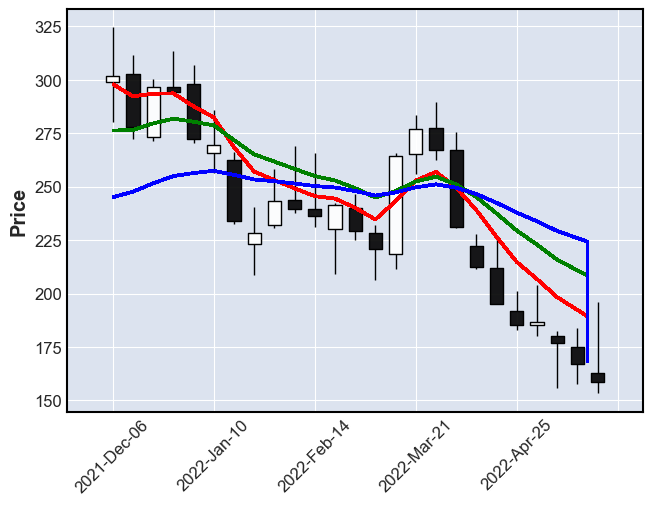

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit
In,,,,,,,,,,,
425,298.799988,324.489990,280.380005,301.980011,298.009394,276.243656,245.013792,nn,nn,2021-12-06,17.727942
426,302.489990,311.600006,272.500000,278.010010,292.295284,276.515403,247.653489,nn,nn,2021-12-13,17.727942
427,273.049988,300.589996,271.450012,296.399994,293.468059,279.574571,251.553210,nn,nn,2021-12-20,17.727942
428,296.600006,313.299988,293.309998,294.109985,293.651466,281.810788,254.957752,nn,nn,2021-12-27,17.727942
429,298.149994,307.109985,270.570007,272.470001,287.599619,280.373744,256.358732,nn,nn,2022-01-03,17.727942
430,265.809998,285.950012,256.440002,269.420013,282.405446,278.688555,257.403634,nn,nn,2022-01-10,17.727942
431,262.600006,266.380005,232.630005,233.740005,268.501034,271.773393,255.510544,nn,nn,2022-01-17,17.727942
432,223.300003,240.570007,208.880005,228.399994,257.043594,265.100563,253.341700,nn,nn,2022-01-24,17.727942
433,231.820007,258.170013,230.520004,243.190002,253.085425,261.729707,252.529564,nn,nn,2022-01-31,17.727942


In [413]:
import mplfinance as mpf
Dates = trades_df['Datetime']

if mover == 0 and switch == False:
    mover = 0
    print("Row start: ",mover) 
    print("Trade: ", 1)
    switch = True
else:
    mover += displayed_candles
    print("Row start: ",mover) 
    print("Trade: " + str(int(mover/displayed_candles)) + " (" + str(int(len(trades_df)/displayed_candles)) + ")") 

lower = mover
upper = mover + displayed_candles

selected_df = trades_df.iloc[lower:upper,:-1]
#print(selected_df)

#Get EMAs
dates = selected_df['Datetime']
ema6 = selected_df['ema6']
ema12 = selected_df['ema12']
ema24 = selected_df['ema24']
datepairs_ema6 = [(d1,d2) for d1,d2 in zip(dates,ema6)]
datepairs_ema12 = [(d1,d2) for d1,d2 in zip(dates,ema12)]
datepairs_ema24 = [(d1,d2) for d1,d2 in zip(dates,ema24)]
#datepairs_ema16

# #Format Dataframe
quotes = selected_df.iloc[:,:10]
quotes['Datetime'] = quotes['Datetime'].astype('datetime64')
quotes = quotes.set_index('Datetime')
quotes = quotes.iloc[:displayed_candles,:4]
quotes.columns=['open','high','low','close']

#Define function to get entry
EntryPriceRow = 0
def GetEntryPriceColl(candle):
    if candle == 'Previous High':
        EntryPriceColl = 1
        EntryPriceRow = 1
    if candle == 'Current Open':
        EntryPriceColl = 0
        EntryPriceRow = 0
    if candle == 'Previous Close':
        EntryPriceColl = 3
        EntryPriceRow = 1
    return EntryPriceColl, EntryPriceRow
entry_price_column,entry_price_row = GetEntryPriceColl(entry_candle)  #
# budget = 10000

entry = selected_df.iloc[window_size-1-entry_price_row,entry_price_column]
profit = selected_df.iloc[window_size-1,-1]
print(entry)
real_profit = round((budget / entry)*profit,2)
print("\nBudget: ",budget)

print("\nEntry price: ",round(entry,2))
print("Label (target): ",round(selected_df.iloc[window_size-1,7],2))
print("Model prediction: ",round(selected_df.iloc[window_size-1,8],2))
print("\nProfit: ",round(selected_df.iloc[window_size-1,-1],3))
print("Real Profit: " + str(real_profit) + " dollars (budget " + str(budget) + ")")

#two_points  = [('2018-07-31',48),('2018-08-01',49)]

mpf.plot(quotes,type='candle',alines=dict(alines=[datepairs_ema6,datepairs_ema12,datepairs_ema24],colors=['r','g','b'])) # datepairs_ema12,datepairs_ema24
#mpf.plot(quotes,type='candle')

selected_df

<b>Investigate losing trades</b>

In [108]:
# selected_df

In [414]:
raw_data = pd.read_csv('nvda_stock_raw_initial_df.csv')

In [421]:
# losing_trades = trades_df[trades_df['profit']<0]
# losing_trades.tail(25)

In [418]:
# loss_trade = raw_data[raw_data['Date'] > "2020-09-21"]
# loss_trade.head(25)

<b>Create Report</b>

In [422]:
trades_df.to_csv('trades_df.csv')
trades_df = trades_df.reset_index()
#trades_df = trades_df.set_index('index')

try:
    trades_df = trades_df.drop('level_0',axis=1)
    trades_df = trades_df.drop('In',axis=1)
except:
    pass
trades_df.tail(20)

,index,In,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit,Trades
455,455,580,230.350006,242.169998,208.899994,241.570007,244.412359,252.883752,249.584201,nn,nn,2022-02-21,19.585984,19
456,456,581,239.919998,246.649994,224.820007,229.360001,240.111685,249.264714,247.966265,nn,nn,2022-02-28,19.585984,19
457,457,582,228.169998,232.199997,206.500000,221.000000,234.651204,244.916296,245.808964,nn,nn,2022-03-07,19.585984,19
458,458,583,218.690002,265.690002,211.589996,264.529999,243.188002,247.933789,247.306646,nn,nn,2022-03-14,19.585984,19
459,459,584,265.070007,283.579987,255.750000,276.920013,252.825720,252.393208,249.675716,nn,nn,2022-03-21,19.585984,19
460,460,585,277.559998,289.459991,262.670013,267.119995,256.909798,254.658868,251.071258,nn,nn,2022-03-28,19.585984,19
461,461,586,267.279999,275.579987,230.619995,231.190002,249.561285,251.048273,249.480758,nn,nn,2022-04-04,19.585984,19
462,462,587,222.139999,227.770004,211.630005,212.580002,238.995204,245.130077,246.528697,nn,nn,2022-04-11,19.585984,19
463,463,588,212.000000,226.699997,195.000000,195.149994,226.468001,237.440834,242.418401,nn,nn,2022-04-18,19.585984,19
464,464,589,192.020004,201.279999,182.899994,185.470001,214.754287,229.445321,237.862529,nn,nn,2022-04-25,19.585984,19


In [423]:
try:
    raw_data = raw_data.drop('Unnamed: 0',axis=1)
except:
    pass
raw_data

,Date,Open,High,Low,Close,EMA6,EMA12,EMA24
0,1999-01-18,0.437500,0.488281,0.388021,0.410156,NaN,NaN,NaN
1,1999-01-25,0.442708,0.467448,0.395833,0.395833,NaN,NaN,NaN
2,1999-02-01,0.395833,0.416667,0.360677,0.412760,NaN,NaN,NaN
3,1999-02-08,0.415365,0.437500,0.372396,0.434896,NaN,NaN,NaN
4,1999-02-15,0.442708,0.460938,0.393229,0.434896,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1224,2022-07-04,141.750000,160.369995,140.550003,158.380005,164.056589,178.129151,198.670124
1225,2022-07-11,155.259995,157.820007,144.649994,157.619995,162.217562,174.973896,195.386113
1226,2022-07-18,163.020004,181.440002,160.020004,173.190002,165.352545,174.699451,193.610424
1227,2022-07-25,170.190002,182.440002,164.779999,181.630005,170.003248,175.765690,192.651991


In [424]:
trades_df.head()
entry_candle

'Current Open'

In [425]:
performance_report = trades_df.copy()

# def Get_hold_period(df,date_from,profit):
#     period = 0
    
#     if profit < 0:
#         condition = df['Date'] == date_from
#         sorted_df = df[condition]
#         print(sorted_df)
#         st_temp = sorted_df.reset_index()
#         first_boundary = st_temp.loc[0,'index']
#         c = 0
#         period = 0
#         while c < 5:
#             c += 1
#             print(raw_data.loc[first_boundary+c,'High'])
#             target = raw_data.loc[first_boundary+c,'High']

#             if target != entry:
#                 period = c
#                 break

#     return period

def profit_calculation(difference,stock_price,budget):
    qty = round(budget/stock_price,0)
    
    return round(difference * qty)

EntryPriceRow = 0
def GetEntryPriceColl(candle):
    if candle == 'Previous High':
        EntryPriceColl = 'high'
        EntryPriceRow = 1
    if candle == 'Current Open':
        EntryPriceColl = 'opens'
        EntryPriceRow = 0
    if candle == 'Previous Close':
        EntryPriceColl = 'close'
        EntryPriceRow = 1
    return EntryPriceColl, EntryPriceRow

entry_coll, entry_row = GetEntryPriceColl(entry_candle) #

budget = 10000

for row in range(24,len(performance_report),25):
    #Get data items
    #print(row)
    #print(performance_report.loc[row-1,'high'])
    entry = performance_report.loc[row-entry_row,entry_coll]
    difference = performance_report.loc[row,'profit']
    prediction = performance_report.loc[row,'prediction']
    ent_date = performance_report.loc[row-1,'Datetime']
    
    #Fill data
    performance_report.loc[row,'Entry'] = entry
    performance_report.loc[row,'Performance'] = profit_calculation(difference,entry,budget)
    #performance_report.loc[row,'Holding period'] = Get_hold_period(raw_data,ent_date,difference)
    
performance_report = performance_report.fillna("nn")

<b>Reorder columns</b>

In [426]:
performance_report = performance_report[['Datetime', 'opens', 'high', 'low','close','ema6','ema12','ema24','Entry','labels','prediction','profit','Performance','Trades']]

In [427]:
performance_report.tail(26)

,Datetime,opens,high,low,close,ema6,ema12,ema24,Entry,labels,prediction,profit,Performance,Trades
449,2022-06-06,160.000000,173.300003,140.550003,158.380005,158.057503,158.057503,158.057503,160.0,173.300003,175.812102,-1.619995,-100.0,18
450,2022-01-17,262.600006,266.380005,232.630005,233.740005,268.501034,271.773393,255.510544,nn,nn,nn,19.585984,nn,19
451,2022-01-24,223.300003,240.570007,208.880005,228.399994,257.043594,265.100563,253.341700,nn,nn,nn,19.585984,nn,19
452,2022-01-31,231.820007,258.170013,230.520004,243.190002,253.085425,261.729707,252.529564,nn,nn,nn,19.585984,nn,19
453,2022-02-07,243.720001,269.250000,237.729996,239.490005,249.201020,258.308215,251.486399,nn,nn,nn,19.585984,nn,19
454,2022-02-14,239.339996,265.820007,231.000000,236.419998,245.549299,254.940797,250.281087,nn,nn,nn,19.585984,nn,19
455,2022-02-21,230.350006,242.169998,208.899994,241.570007,244.412359,252.883752,249.584201,nn,nn,nn,19.585984,nn,19
456,2022-02-28,239.919998,246.649994,224.820007,229.360001,240.111685,249.264714,247.966265,nn,nn,nn,19.585984,nn,19
457,2022-03-07,228.169998,232.199997,206.500000,221.000000,234.651204,244.916296,245.808964,nn,nn,nn,19.585984,nn,19
458,2022-03-14,218.690002,265.690002,211.589996,264.529999,243.188002,247.933789,247.306646,nn,nn,nn,19.585984,nn,19


In [428]:
# performance_report.to_csv('nvda_80_performance_report.csv')

In [429]:
performance_report.to_excel('nvda_80_performance_report.xlsx')

In [430]:
trades_df.to_excel('trades_df.xlsx')